In [59]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, types
from numba.typed import List
import numpy.random as npr

In [60]:
@jit(nopython=True)
def find_growth_candidates(domain):
    candidates = List()
    for i in range(1, domain.shape[0] - 1):
        for j in range(1, domain.shape[1] - 1):
            # Check only horizontal and vertical neighbors
            if domain[i, j] == 0 and (domain[i-1, j] == 1 or domain[i+1, j] == 1 or domain[i, j-1] == 1 or domain[i, j+1] == 1):
                candidates.append((i, j))
    return candidates

In [88]:
# SOR method to solve the Laplace equation
@jit(nopython=True)
def solve_laplace(concentration, domain, omega, epsilon):
    theta = np.float32(1e20)  
    iteration = 0  # Counter for iterations

    height, width = concentration.shape  
    while theta > epsilon:
        max_change = np.float32(0)
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                if domain[i, j] == 0:  # Update only if not part of the cluster
                    old_value = concentration[i, j]
                    # Compute the new concentration value
                    concentration[i, j] = (omega / 4) * (concentration[i+1, j] + concentration[i-1, j] + concentration[i, j+1] + concentration[i, j-1]) +  (1 - omega) * old_value
                    # Update the maximum change if necessary
                    max_change = max(max_change, np.abs(concentration[i, j] - old_value))
                else:
                    concentration[i, j] = 0  # Explicitly set concentration to zero if part of the cluster
                    
        iteration += 1

        # Update theta for the while-loop condition
        theta = max_change
    return concentration


In [85]:
# Growth function
# @jit(nopython=True)
def grow(domain, concentration, omega, eta, epsilon):
    concentration = solve_laplace(concentration, domain, omega, epsilon)
    candidates = find_growth_candidates(domain)
    if not candidates:
        return domain, concentration  # No more growth possible

    # Check if nutrient concentration exists
    has_nutrients = np.any(concentration[c[0], c[1]] > 0 for c in candidates)
    if not has_nutrients:
        return domain, concentration  # Stop growth due to lack of nutrients

    # Filter out candidates with zero concentration
    valid_candidates = [(i, j) for i, j in candidates if concentration[i, j] > 0]
    if not valid_candidates:
        return domain, concentration

    # Compute probabilities only for valid candidates
    probabilities = [concentration[i, j] ** eta if concentration[i, j] > 0 else 0 for i, j in valid_candidates]
    sum_probabilities = np.sum(probabilities)

    # Normalize the probabilities to ensure they sum to 1
    if sum_probabilities > 0:  # Prevent division by zero
        probabilities = [prob / sum_probabilities for prob in probabilities]
    else:  # In case all probabilities are zero, distribute chances equally among valid candidates
        probabilities = [1 / len(valid_candidates)] * len(valid_candidates)

    # Select and add new growth site
    index = np.random.choice(len(valid_candidates), p=probabilities)
    growth_site = valid_candidates[index]
    domain[growth_site] = 1
    return domain, concentration


In [63]:
# @jit(nopython=True)
def sim(domain, concentration, omega, iterations, eta, epsilon):
    iter_count = 0
    for _ in range(iterations):
        domain, concentration = grow(domain, concentration, omega, eta, epsilon)
    return domain, concentration

In [64]:
# @jit(nopython=True)
def num_seeds(domain):
    return np.sum(domain)

In [101]:
size = 100  # Size of the domain
seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 300  # Number of growth steps
omega = 1.85  # Over-relaxation parameter
epsilon = 1e-5  # epsilon for SOR convergence
eta = 1  # Shape parameter

# Initialize domain
domain = np.zeros((size, size), dtype=np.float32)  # Ensure dtype is specified
domain[seed_position] = 1  # Place the initial seed

# Initialize the nutrient concentration grid with highest concentration at the top
concentration = np.linspace(1, 0, size, dtype=np.float32).reshape(-1, 1)  # Ensure dtype is specified
concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

domain, concentration = sim(domain, concentration, omega, iterations, eta, epsilon)
print(f"Number of seeds: {num_seeds(domain)}")

Number of seeds: 301.0


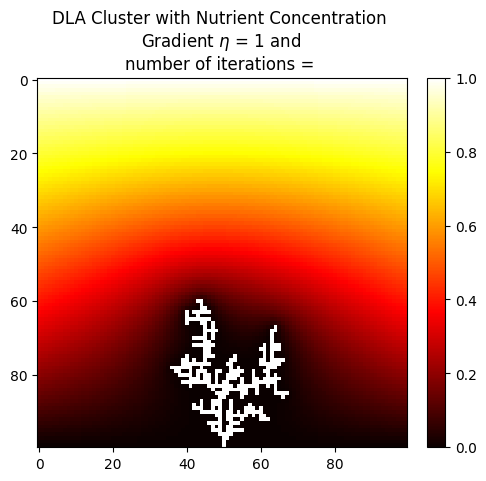

In [102]:
fig, ax = plt.subplots()
cmap = ax.imshow(concentration, cmap='hot', interpolation='nearest')
fig.colorbar(cmap, ax=ax, fraction=0.046, pad=0.04)
cluster_overlay = np.ma.masked_where(domain == 0, domain)
ax.imshow(cluster_overlay, cmap='Greys', interpolation='nearest')
ax.set_title(f'DLA Cluster with Nutrient Concentration \nGradient $\eta$ = {eta} and \nnumber of iterations = ')
plt.show()

0.0
0.5
1.0
1.5
2.0


C:\Users\koenw\AppData\Local\Temp\ipykernel_11012\3196115436.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


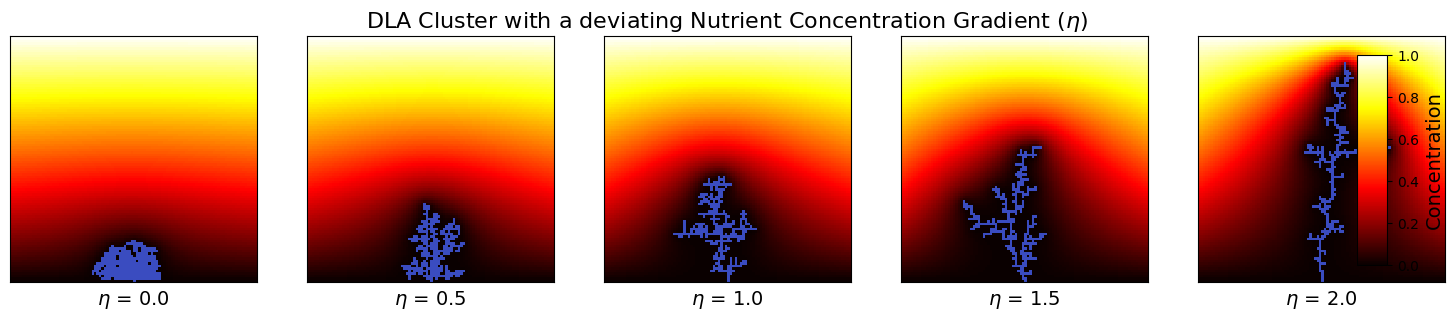

In [104]:
eta_list = np.linspace(0, 2, 5)

# Plotting
fig, axes = plt.subplots(1, len(eta_list), figsize=(15, 3))

for i, eta in enumerate(eta_list):
    # Parameters
    size = 100  # Size of the domain
    seed_position = (size - 1, size // 2)  # Seed at the bottom center
    iterations = 300  # Number of growth steps
    omega = 1.85  # Over-relaxation parameter
    epsilon = 1e-5  # epsilon for SOR convergence

    # Initialize domain
    domain = np.zeros((size, size))
    domain[seed_position] = 1  # Place the initial seed

    # Initialize the nutrient concentration grid with highest concentration at the top
    concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Gradient from top (1) to bottom (0)
    concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

    ax = axes[i]
    domain, concentration = sim(domain, concentration, omega, iterations, eta, epsilon)
    cmap = ax.imshow(concentration, cmap='hot', interpolation='nearest')
    cluster_overlay = np.ma.masked_where(domain == 0, domain)
    im = ax.imshow(cluster_overlay, cmap = 'coolwarm', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"$\eta$ = {eta}", fontsize=14)
    print(eta)

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Concentration', fontsize=14)

axes[2].set_title(f'DLA Cluster with a deviating Nutrient Concentration Gradient ($\eta$)', fontsize=16, loc='center')

plt.tight_layout()
plt.show()

In [39]:
seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 300  # Number of growth steps
epsilon = 1e-5  # epsilon for SOR convergence
size = 100  # Size of the domain

for eta in np.linspace(0, 2, 5):
    n_iter = []
    for omega in np.arange(1.7, 1.99, 0.05):
        temp_iter = []

        # Initialize domain
        domain = np.zeros((size, size))
        domain[seed_position] = 1  # Place the initial seed

        # Initialize the nutrient concentration grid with highest concentration at the top
        concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Gradient from top (1) to bottom (0)
        concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

        domain, concentration, count = sim(domain, concentration, omega, iterations, eta)
        temp_iter.append(count)
        print(omega)
    n_iter.append(np.mean(temp_iter))

    plt.plot(np.linspace(1.7, 1.99, len(n_iter)), n_iter, label = f"$\eta$ = {eta}")
    plt.scatter(np.linspace(1.7, 1.99, len(n_iter)), n_iter, s=5)

plt.legend()
plt.grid(True)
plt.xlabel('Omega $(\omega)$')
plt.ylabel('Iterations')
plt.title('Number of iterations needed to form a DLA Cluster \nfor Optimal $\omega$ by varying $\eta$')

plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:30: SyntaxWarning: invalid escape sequence '\o'
C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:23: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(np.linspace(1.7, 1.99, len(n_iter)), n_iter, label = f"$\eta$ = {eta}")
C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:28: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Omega $(\omega)$')
C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:30: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Number of iterations needed to form a DLA Cluster \nfor Optimal $\omega$ by varying $\eta$')


1.7
1.75


C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:23: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(np.linspace(1.7, 1.99, len(n_iter)), n_iter, label = f"$\eta$ = {eta}")
C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:28: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Omega $(\omega)$')
C:\Users\sacha\AppData\Local\Temp\ipykernel_32772\886851959.py:30: SyntaxWarning: invalid escape sequence '\o'
  plt.title('Number of iterations needed to form a DLA Cluster \nfor Optimal $\omega$ by varying $\eta$')


KeyboardInterrupt: 

In [ ]:
seed_position = (size - 1, size // 2)  # Seed at the bottom center
iterations = 1000  # Number of growth steps
omega = 1.9  # Over-relaxation parameter
epsilon = 1e-5  # epsilon for SOR convergence
size = 100  # Size of the domain

for eta in np.arange(0.01, 100, 10):
    n_iter = []
    for omega in np.arange(1.7, 1.99, 0.05):
        temp_count = []
        for runs in range(5):
            # Initialize domain
            domain = np.zeros((size, size))
            domain[seed_position] = 1  # Place the initial seed

            # Initialize the nutrient concentration grid with highest concentration at the top
            concentration = np.linspace(1, 0, size).reshape(-1, 1)  # Gradient from top (1) to bottom (0)
            concentration = np.tile(concentration, (1, size))  # Extend the gradient horizontally

            domain, concentration, count = sim(domain, concentration, omega, iterations, eta)
            temp_count.append(count)
            
        n_iter.append(np.mean(temp_count))
        print(omega)

    plt.plot(np.linspace(1.7, 1.99, len(n_iter)), n_iter, label = f"$\eta$ = {eta}")
    plt.scatter(np.linspace(1.7, 1.99, len(n_iter)), n_iter, s=5)

plt.legend()
plt.grid(True)
plt.xlabel('Omega $(\omega)$')
plt.ylabel('Iterations')
plt.title('Number of iterations needed to form a DLA Cluster \nfor Optimal $\omega$ by varying $\eta$')

plt.show()

# Monte Carlo


In [ ]:
def run_dla(size, seed_position, num_walkers):
    domain = np.zeros((size, size), dtype=int)
    domain[seed_position] = 1  # Start with a seed

    # Function for performing a single random walk
    def random_walk():
        # Start position for the walker at the top boundary
        x, y = 0, np.random.randint(size)
        
        # Perform the walk until the walker sticks or exits the domain
        while True:
            # Step
            step_x, step_y = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
            # No diags
            if step_x != 0 and step_y != 0:
                continue
            
            x, y = x + step_x, (y + step_y) % size  # Apply periodic boundary conditions horizontally
            
            # Check top and bottom boundaries
            if x < 0:
                x = 0  # Reset to top if it tries to move out from top
            elif x >= size:
                return False  # Remove walker if it moves out from the bottom
            
            # Check if next to the cluster
            if np.any(domain[max(0, x-1):min(size, x+2), max(0, y-1):min(size, y+2)] == 1):
                return (x, y)  # Walker sticks

    # Main loop for DLA growth
    for _ in range(num_walkers):
        result = random_walk()
        if result:
            domain[result] = 1  # Add new point to the cluster

    return domain

In [ ]:
# Parameters
size = 100
seed_position = (size - 1, size // 2)  # Starting at the bottom center
num_walkers = 1000  # Number of walkers

# Run simulation
domain = run_dla(size, seed_position, num_walkers)

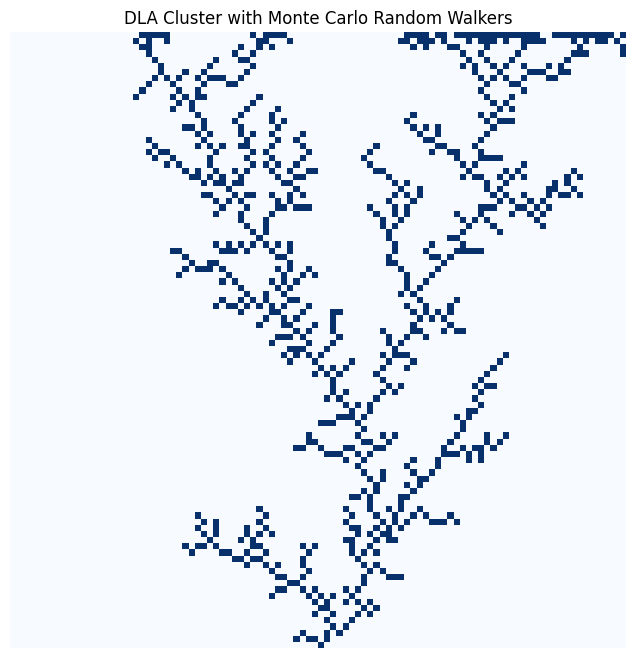

In [ ]:
# Plot the result
plt.figure(figsize=(8, 8))
plt.imshow(domain, cmap='Blues')
plt.title('DLA Cluster with Monte Carlo Random Walkers')
plt.axis('off')
plt.show()


In [ ]:
def run_dla(size, seed_position, num_walkers, stick_probs):
    results = []

    for ps in stick_probs:
        domain = np.zeros((size, size), dtype=int)
        domain[seed_position] = 1  # Start with a seed

        # Function for performing a single random walk
        def random_walk():
            x, y = 0, np.random.randint(size)  # Start from top boundary
            
            while True:
                step_x, step_y = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
                if step_x != 0 and step_y != 0:  # Prevent diagonal movement
                    continue

                x, y = x + step_x, (y + step_y) % size  # Apply periodic boundary conditions horizontally
                
                if x < 0:  # Reset to top if moving out from top
                    x = 0
                elif x >= size:  # Remove walker if it moves out from bottom
                    return False
                
                # Check if next to the cluster
                if np.any(domain[max(0, x-1):min(size, x+2), max(0, y-1):min(size, y+2)] == 1):
                    # Stick with probability ps
                    if np.random.random() < ps:
                        return (x, y)  # Walker sticks

        # Main loop for DLA growth
        for _ in range(num_walkers):
            result = random_walk()
            if result:
                domain[result] = 1  # Add new point to the cluster

        results.append((ps, domain.copy()))

    return results


In [ ]:

# Parameters
size = 100
seed_position = (size - 1, size // 2)  # Starting at the bottom center
num_walkers = 5000  # Number of walkers
stick_probs = [0.1, 0.5, 0.9]  # Different sticking probabilities

# Run simulations
results = run_dla(size, seed_position, num_walkers, stick_probs)

KeyboardInterrupt: 

In [ ]:
# Plotting results
fig, axs = plt.subplots(1, len(stick_probs), figsize=(20, 5))
for i, (ps, domain) in enumerate(results):
    axs[i].imshow(domain, cmap='Reds')
    axs[i].set_title(f'p_s = {ps}')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [31]:
@jit(nopython=True)
def gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps):    
    # Stability condition check (for explicit scheme)
    assert (4 * D_u * dt) / (dx**2) <= 1, "The simulation might be unstable, adjust parameters."
    assert (4 * D_v * dt) / (dx**2) <= 1, "The simulation might be unstable, adjust parameters."

    # Initialize grid
    u = np.zeros((grid_size, grid_size))
    v = np.zeros((grid_size, grid_size))

    # For the initial conditions, you can take u = 0.5 everywhere in the system
    u[:, :] = 0.5
    
    # take v = 0.25 in a small square in the center of the system, and 0 outside.
    v[grid_size//4:3*grid_size//4, grid_size//4:3*grid_size//4] = 0.25
    # v[grid_size//2-5:grid_size//2+5, grid_size//2-5:grid_size//2+5] = 0.25

    # add small amount of noise to the system
    v += np.random.normal(0, 0.05, (grid_size, grid_size))
    u += np.random.normal(0, 0.05, (grid_size, grid_size))

    # Diffusion simulation only along y-axis
    for step in range(steps):
        for i in range(1, grid_size-1):
            for j in range(1, grid_size-1):
                laplacian_u = (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - 4 * u[i, j]) / dx**2
                laplacian_v = (v[i+1, j] + v[i-1, j] + v[i, j+1] + v[i, j-1] - 4 * v[i, j]) / dx**2
                reaction = u[i, j] * v[i, j]**2
                u[i, j] += D_u * dt * laplacian_u - reaction + f * (1 - u[i, j])
                v[i, j] += D_v * dt * laplacian_v + reaction - (f + k) * v[i, j]


                # u[i, j] = u[i, j] + D_u * dt / dx**2 * (u[i+1, :] + u[i-1, :] + u[:, j+1] + u[:, j-1]  - 4 * u[i, j]) - u[i, j] * v[i, j]**2 + f*(1 - u[i, j])
                # v[i, j] = v[i, j] + D_v * dt / dx**2 * (v[i+1, :] + v[i-1, :] + v[:, j+1] + v[:, j-1]  - 4 * v[i, j]) - u[i, j] * v[i, j]**2 - (f + k) * v[i, j]

        # Periodic boundary condition
        u[:, -1] = u[:, 0]
        u[-1, :] = u[0, :]
        v[:, -1] = v[:, 0]
        v[-1, :] = v[0, :]
        
    return u, v

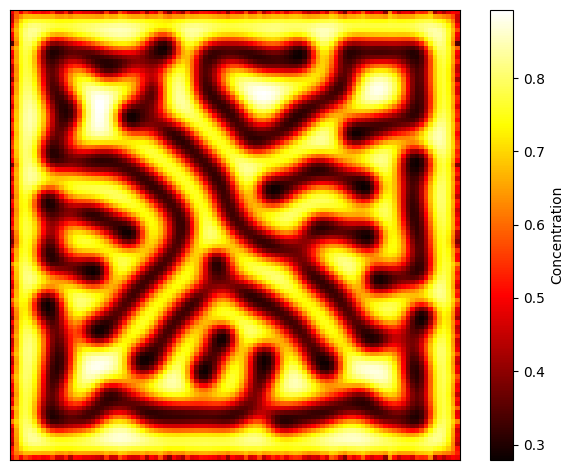

In [32]:
# Parameters
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
f = 0.035  # Feed rate, arbitrary units
k = 0.060  # Kill rate, arbitrary units
steps = 2000 # Number of time steps to simulate

u, v = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
plt.imshow(u, cmap='hot', interpolation='nearest')
plt.xlabel(f"t = {np.round(dt)}")
plt.colorbar(label='Concentration')

#hide axis
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# plt.title(f'Concentration After {steps} Steps and time = {1} \n (Y-axis diffusion only)')
plt.tight_layout()
plt.show()

C:\Users\sacha\AppData\Local\Temp\ipykernel_10876\1316258330.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\sacha\AppData\Local\Temp\ipykernel_10876\1316258330.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


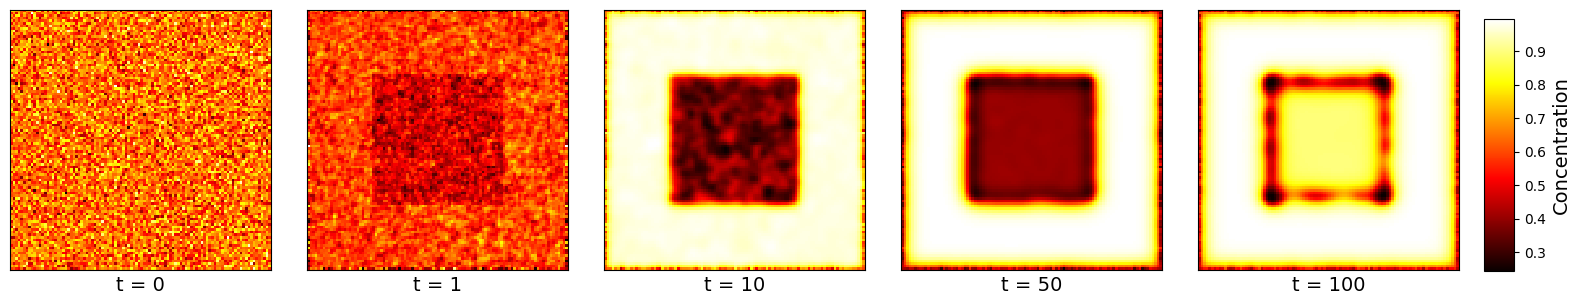

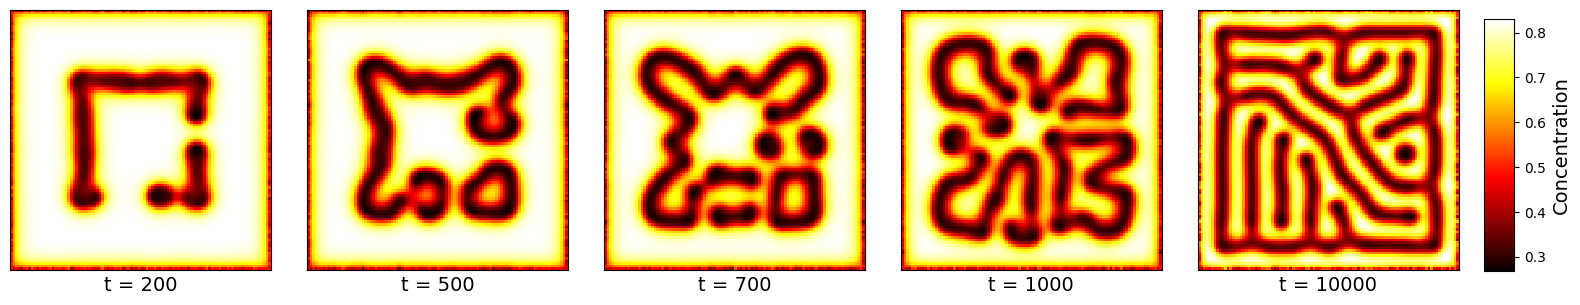

In [40]:
grid_size = 100
dt = 1  # Time step, arbitrary units
dx = 1  # Grid spacing, arbitrary units
D_u = 0.16  # Diffusion coefficient, arbitrary units
D_v = 0.08  # Diffusion coefficient, arbitrary units
f = 0.035  # Feed rate, arbitrary units
k = 0.060  # Kill rate, arbitrary units

steps_list = [0, 1, 10, 50, 100]

# Plotting
fig, axes = plt.subplots(1, len(steps_list), figsize=(15, 3))

for i, steps in enumerate(steps_list):
    u, v = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
    ax = axes[i]
    im = ax.imshow(u, cmap='hot', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"t = {steps}", fontsize=14)

# Add colorbar
cbar_ax = fig.add_axes([1, 0.08, 0.02, 0.84])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Concentration', fontsize=14)

# Set title for the last subplot
# axes[2].set_title(f'Concentration diffusion for different times (Y-axis diffusion only)', fontsize=16, loc='center')

plt.tight_layout()

steps_list = [200, 500, 700, 1000, 10000]

# Plotting
fig, axes = plt.subplots(1, len(steps_list), figsize=(15, 3))

for i, steps in enumerate(steps_list):
    u, v = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)
    ax = axes[i]
    im = ax.imshow(u, cmap='hot', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(f"t = {steps}", fontsize=14)

# Add colorbar
cbar_ax = fig.add_axes([1, 0.08, 0.02, 0.84])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Concentration', fontsize=14)

plt.tight_layout()
plt.show()

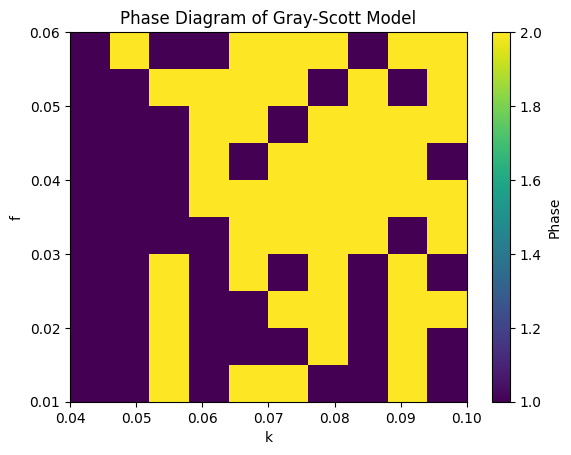

In [37]:
from scipy.ndimage import label

# Parameters
grid_size = 100
dt = 1  # Time step
dx = 1  # Space step
D_u = 0.16  # Diffusion coefficient for U
D_v = 0.08  # Diffusion coefficient for V
steps = 2000  # Number of time steps

# Define parameter ranges
f_range = np.linspace(0.01, 0.06, 10)
k_range = np.linspace(0.04, 0.1, 10)

# Initialize arrays to store phase information
phases = np.zeros((len(f_range), len(k_range)))

# Simulate Gray-Scott model for each parameter combination
for i, f in enumerate(f_range):
    for j, k in enumerate(k_range):
        # Simulate Gray-Scott model
        u, v = gray_scott(grid_size, D_u, D_v, f, k, dt, dx, steps)

        # Apply basic pattern recognition
        labeled_array, num_features = label(u > 0.5)  # Label connected regions where u > 0.5

        # Assign phase label based on the number of features
        # Example: if multiple features are observed, assign phase label 1 (spots)
        # Example: if a single feature is observed, assign phase label 2 (stripes)
        if num_features > 1:
            phase_label = 1  # Spots
        else:
            phase_label = 2  # Stripes

        # Store phase label in phases array
        phases[i, j] = phase_label

# Plot phase diagram
plt.imshow(phases, extent=[k_range[0], k_range[-1], f_range[0], f_range[-1]], aspect='auto', cmap='viridis')
plt.colorbar(label='Phase')
plt.xlabel('k')
plt.ylabel('f')
plt.title('Phase Diagram of Gray-Scott Model')
plt.show()